<a href="https://colab.research.google.com/github/parviza9999/Linkedin/blob/main/MLS_Content_Generation_and_Summarization_with_Gen_AI_AWS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<h1><b>Text-to-Text tasks with AWS Bedrock API</b>
</center>

**Case Study: Youtube Video Summarization**

With the advent of Large Language Models (LLMs), the market has seen an influx of standalone tools and products built on these technologies. Among the pioneering applications were **YouTube summarization tools** such as Monica, Notta, and NoteGPT, and summarization. These products have significantly enhanced user productivity across various use cases.

Today, we aim to replicate the functionality of such products.

## **Problem Definition**


Company **Great Learning** produces a vast amount of educational content, but the volume of content can overwhelm their audience. Many users seek quick, concise summaries to determine whether they want to engage with the full content. Currently, Great Learning's team manually summarizes content, which is time-consuming and prone to inconsistencies. The company needs an efficient, automated solution to generate accurate and engaging summaries. By doing so, they can save time, reduce costs, and enhance user satisfaction.

## Setup

This notebook needs to be executed with a GPU runtime since we load a transformer model to disk and use it to evaluate text-to-text tasks. Transformer models benefit from parallel execution offered by a GPU runtime and can have a significant impact on execution times (for e.g., code in this notebook runs up to 4 times faster witha GPU). Follow the screenshots below to create a GPU runtime on a Colab instance.

*Step 1:*

Select the `Runtime` option from the main menu and select the `Change runtime type` from the dropdown.

In [2]:
from PIL import Image

img = Image.open('/content/rt1.png')
display(img)

FileNotFoundError: [Errno 2] No such file or directory: '/content/rt1.png'

Select `T4 GPU` from the options presented under Hardware accelerator.

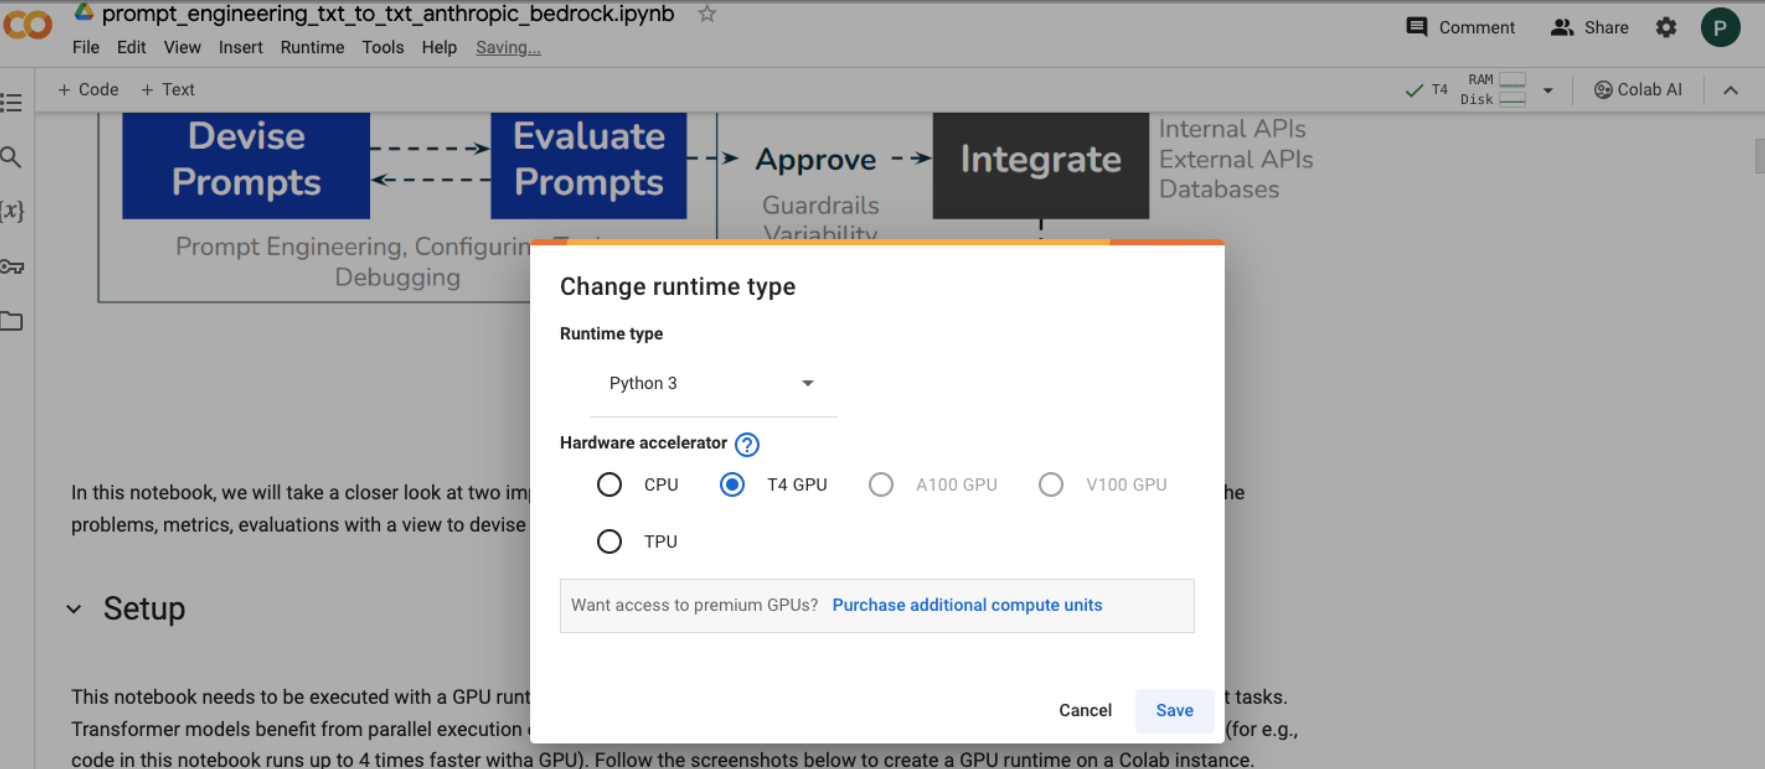

In [ ]:
img = Image.open('/content/rt2.png')
display(img)

You should now see the T4 GPU mentioned in the runtime logo

In [1]:
img = Image.open('/content/rt3.png')
display(img)

NameError: name 'Image' is not defined

## Installations, Imports and Authentication

Let's import the necessary libraries.

In [3]:
!pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 11.2 MB/s eta 0:00:00


In [4]:
!pip install pytube==15.0 openai==1.2.0 tiktoken datasets evaluate bert_score openai-whisper --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.9/219.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.6/798.6 kB 14.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.

In [5]:
import boto3
import json
import evaluate
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
from collections import Counter
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import textwrap
from pytube import YouTube
from IPython.display import YouTubeVideo

### Authentication

In [6]:
!mkdir ~/.aws
!cp aws_config.ini ~/.aws/credentials

In [7]:
client = boto3.client("bedrock-runtime")
model_id = "anthropic.claude-instant-v1"

## **Step 1 - Data Preparation**

Great Learning wants to convert there online sessions, webinars and podcast to audio file which can be used later to generate transcript. We will be using **pytube** library to convert youtube video into audio file and **OpenAI Whisper** library for the transcript generation.

**What is Whisper AI?**

**Whisper AI** is developed by OpenAI for automatic speech recognition (ASR), which transcribes spoken language into text. It was trained on a massive dataset of 680,000 hours of multilingual, supervised data from the internet, allowing it to handle a wide variety of accents, vocabularies, and topics. Whisper breaks down input speech into phonetic components and compares them against its knowledge base to determine the most probable sequence of words, enabling it to transcribe speech with high accuracy. The Whisper model has diverse applications including transcribing meetings, converting educational materials into text, enabling voice assistants, and automatic captioning

You can read more about whisper below:
- <a href="https://openai.com/index/whisper/">OpenAI Whisper</a>
- <a href="https://github.com/openai/whisper/blob/main/model-card.md">Model Types</a>

### Convert YouTube Video to Audio File
**Business Perspective:** Great Learning has a large repository of video content on YouTube and other platforms. To summarize these videos, the first step is to extract the audio. Audio files are easier and faster to process for transcription compared to video files. Using **pytube**, Great Learning can download videos from YouTube and convert them into audio files in a business-friendly man

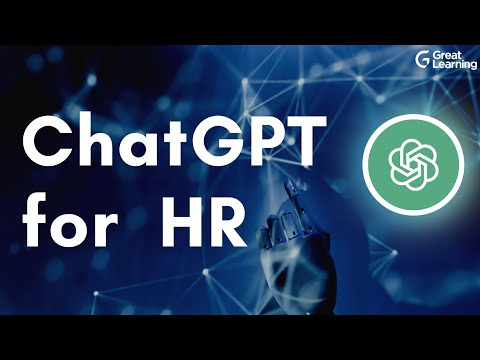

In [8]:
#  Mention only the last segment of the youtube video link
YouTubeVideo('8l8fpR7xMEQ')

In [9]:
# Link to the youtube video
video_path = "https://www.youtube.com/watch?v=8l8fpR7xMEQ"

In [10]:
# url input from user
yt = YouTube(video_path)

# extract only audio
video = yt.streams.filter(only_audio=True).first()

# check for destination to save file. Here '.' represents taht the destination will be the current directory
destination = '.'

# download the file
out_file = video.download(output_path=destination)

# save the file
base, ext = os.path.splitext(out_file)
new_file = base + '.mp3'
os.rename(out_file, new_file)

# result of success
print(yt.title + " has been successfully downloaded.")

How HR Teams can use ChatGPT? - Things you can do with ChatGPT has been successfully downloaded.


In [11]:
audio_path = new_file

In [12]:
audio_path

'/content/./How HR Teams can use ChatGPT - Things you can do with ChatGPT.mp3'

### Audio to Transcript Conversion

**Business Perspective**: Once the audio is extracted, the next step is to transcribe it into text. Accurate transcriptions are crucial for generating reliable summaries. OpenAI-Whisper is an advanced model that can produce high-quality transcriptions, thus ensuring that the subsequent summarization step has a solid foundation.

**Note**: Whisper AI can also use the directly video file(mp4 format) as input for transcript generation, but we are using audio (mp3 format) for the following reasons:
1.  If we use video file (mp4 format), we will need to download it and process it to whisper. On the other hand, audio file (mp3 format) file will be lighter and we can skip the step of getting the downloaded video file.
2. Whisper AI can process 25 MB of data at a time. So we can process more data in mp3 format as compared to mp4 format.

In [13]:
import whisper
model = whisper.load_model("base")
result = model.transcribe(audio_path)

100%|███████████████████████████████████████| 139M/139M [00:26<00:00, 5.58MiB/s]


In [14]:
transcript = result["text"]

In [15]:
print(textwrap.fill(transcript,width = 150))

 You don't need to spend countless hours on researching and crafting job descriptions or for letters and formal email templates anymore. What if we
told you that there's a tool that can help you create effective job descriptions, develop successful onboarding programs, automate document generation
and even help match candidate profiles that are a right fit for a certain role. Say hello to chat GPT, the Revolu fishery language model that's taking
the modern HR world by storm. In this video, we'll introduce you to chat GPT and explain what it is and how it works. You'll learn about the
technology behind this powerful tool and how it can help you with everything from developing interview questions to gathering employee feedback. But
that's not all. If you are interested in diving deeper into the world of HR with chat GPT, we have got you covered. If you're for a full course called
chat GPT for HR on our website, Great Learning Academy that covers a wide range of topics including the role 

## **Step 2 - Devise prompts**

**Business Perspective**: To generate summaries, Great Learning needs to provide clear instructions to the generative AI model. A well-crafted prompt ensures the model understands the task and produces concise and informative summaries without any prior examples (zero-shot prompting).

In [16]:
claude_prompt_template = """

Human: {system_message}
{prompt}

Assistant: {response}
"""

In [17]:
user_message_template = """```{transcript}```"""

**Zero-shot prompt**

Let's create a zero shot prompt that extracts the required insights from the transcript.

We will check if we can achieve this with Zero-Shot Prompting.
Zero-shot prompting is used instead of few-shot prompting primarily because it eliminates the need to manually curate and provide multiple examples for every different type of content. In the context of summarizing YouTube videos, webinars, or podcasts, Company Great Learning deals with a wide variety of topics and formats.
We can further use Chain of Thought prompting to improve the results.

In [18]:
zero_shot_system_message = """You are helpful assistant. Summarize the following youtube transcript in  5-10 lines.
Keep it concise and make sure to include all the important points.
"""

In [19]:
def summarize(transcript, system_message):

    user_message_template = """```{transcript}```"""

    prompt_ = claude_prompt_template.format(
        system_message=system_message,
        prompt=user_message_template.format(transcript=transcript),
        response=''
    )

    payload = json.dumps({
        "prompt": prompt_,
        "max_tokens_to_sample": 1000,
        "temperature": 0
    })

    response = client.invoke_model(
        body=payload,
        modelId=model_id
    )

    response_body = json.loads(response['body'].read())

    return response_body['completion']

In [20]:
summary_response = summarize(transcript,zero_shot_system_message)

Check the generated summary

In [21]:
print(textwrap.fill(summary_response,width = 150))

 Here is a 5-10 line summary:  ChatGPT can help HR professionals with various tasks like creating effective job descriptions, developing onboarding
programs, generating documents, and matching candidate profiles to roles. It demonstrates how ChatGPT can be used to create templates for job
descriptions, offer letters, feedback surveys, and other HR documents. Various examples are provided of using ChatGPT to generate or modify templates
for different HR needs.


Great! It summarizes the important points from the video. For a general youtube summarizer, this is the good summary. But if we were to develop a tool specifically for an audience like students noting down lectures or a 'technical summarizer for developers' that picks up all the little code/techical details from videos, then a more personalised prompt is necessary which can focus on the necessary elements. This can help us create a **specific summarizer**.


### **Impact**

**Automating the summarization process** with generative AI will significantly reduce the time and resources required for manual summarization. This allows Great Learning to allocate their human resources to more strategic tasks, such as content creation and user engagement. Additionally, providing quick summaries enhances the user experience, leading to increased satisfaction and potentially higher engagement rates.

This looks good but it is difficult to manually judge the output given the transcripts are long. Let's evaluate the performance of the LLM through the LLM-as-a-judge framework.

## **Step 3 - Evaluation**

**Business Perspective**: To ensure the quality and accuracy of the summaries, Great Learning needs to evaluate the AI-generated summaries.

We do not have summaries to compare but only the transcripts. Hence ROUGE and BERT scores are out of the window. So, using a **large language model (LLM) as a judge** can provide an objective assessment of the summaries, ensuring they meet the desired standards.We will create a step-by-step instruction for the rater model to perform rating on summary responses.

Let's create a prompt to rate the abstracts provided by the LLM. We will ask the LLM to rate the abstract on multiple metrics and return the ratings in a json format.

In [22]:
rater_system_message = """
You are tasked with rating AI-generated summaries of youtube transcripts based on the given metric.
You will be presented a transcript and an AI generated summary of the transcript as the input.
In the input, the transcript will begin with ###transcript while the AI generated summary will begin with ###summary.

Metric
Check if the summary  is true to the transcript.
The summary should cover all the aspects that are majorly being discussed in the transcript.
The summary should be concise.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the summary.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Respond only with a rating between 0 and 5. Do not explain the rating.
"""

In [23]:
rater_user_message_template = """
###transcript
{transcript}

###summary
{summary}
"""

In [24]:
rater_prompt = f"""
Human: {rater_system_message}

User:
###transcript
{transcript}

###summary
{summary_response}

Assistant:
"""

# Create the payload for the AWS model invocation
payload = json.dumps({
    "prompt": rater_prompt,
    "max_tokens_to_sample": 1,
    "temperature": 0
})

try:
    # Invoke the AWS model
    response = client.invoke_model(
        body=payload,
        modelId=model_id
    )
    response_body = json.loads(response['body'].read())
    rating = response_body['completion'].strip()

except Exception as e:
    print(f"Error processing rating: {e}")  # Better error handling can be implemented here

# Print the ratings
print(rating)


4


### **Impact**
Regular evaluation of AI-generated summaries is critical **for maintaining high-quality standards**. It helps Great Learning **ensure that the summaries are accurate, concise, and useful for their audience**. Continuous feedback allows for iterative improvements, making the AI system more reliable over time. This ongoing evaluation process ensures that the company consistently delivers value to its users, maintaining their trust and engagement.

## **Step 4: Improve the prompt - CoT**

**Business Perspective**: To further enhance the quality of summaries, Great Learning can implement chain of thought prompting. This involves breaking down the summarization process into a series of logical steps, allowing the AI to produce more coherent and detailed summaries.

Let's try CoT prompt and see if it works better.

In [31]:
cot_system_message = """
You are a helpful assistant that summarises youtube transcripts.

Think step-by-step,

Read the YouTube transcript, paying close attention to each sentence and its importance.

Parse the text into meaningful chunks, identifying the main ideas and key points, while ignoring unnecessary details and filler language.

Extract the most crucial information, such as names, dates, events, or statistics, that capture the essence of the content.

Consider the overall theme and message the speaker intends to convey, looking for a central idea or argument.

Begin summarizing by focusing on the main points, using clear and concise language. Ensure the summary maintains the core meaning of the original transcript without unnecessary elaboration.

Provide a brief introduction and conclusion to bookend the summary, stating the key takeaways and any relevant context the viewer might need.

Double-check that the summary is coherent, making sense on its own, and that it represents the original transcript truthfully.

Keep the length reasonable and aligned with the complexity of the content. Aim for a good balance between brevity and inclusivity of essential details.

Use an engaging tone that suits the summary's purpose and aligns with the original video's intent.

Finally, review the summary, editing for grammar, clarity, and any potential biases or misunderstandings the concise language might cause. Ensure it's accessible to the intended audience.

"""

In [32]:
cot_summary_df = summarize(transcript,cot_system_message)

In [33]:
cot_summary_df

' Here is a summary of the YouTube transcript:\n\nChatGPT is an AI language model created by OpenAI that can be helpful for various HR tasks. It can generate templates for job descriptions, offer letters, promotion letters, and other documents just by asking simple questions. It understands context and can modify templates based on additional details provided. \n\nSome ways ChatGPT can assist with HR include creating onboarding programs tailored to specific roles or work environments. It can suggest interview questions for roles like product manager and modify the technical depth. ChatGPT also provides templates for feedback surveys to gather employee insights.\n\nIn summary, ChatGPT acts as a helpful HR assistant that can generate various documents and templates through natural language. This saves HR professionals time on administrative tasks so they can focus on strategic work like engagement, retention and aligning business goals. ChatGPT demonstrates how AI is transforming HR proc

In [34]:
rater_cot_prompt = f"""
Human: {rater_system_message}

User:
###transcript
{transcript}

###summary
{cot_summary_df}

Assistant:
"""

# Create the payload for the AWS model invocation
payload = json.dumps({
    "prompt": rater_cot_prompt,
    "max_tokens_to_sample": 1,
    "temperature": 0
})

try:
    # Invoke the AWS model
    response = client.invoke_model(
        body=payload,
        modelId=model_id
    )
    response_body = json.loads(response['body'].read())
    rating = response_body['completion'].strip()

except Exception as e:
    print(f"Error processing rating: {e}")  # Better error handling can be implemented here

# Print the ratings
print(rating)


5


## **Conclusion**
By implementing this generative AI-driven summarization process, Company Great Learning can significantly improve their **operational efficiency and enhance user satisfaction**. The steps outlined in this case study—from data preparation to continuous evaluation—provide a comprehensive approach to leveraging AI for content summarization. This transformation not only **saves time and resources** but also positions Great Learning as a forward-thinking educational company committed to **delivering high-quality, accessible content**.